In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgbm

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [5]:
df = pd.read_csv('sample_data/data.csv', index_col=0)

---

### 1) Так как целевая переменная - цена, то наибольший интерес изначально представляет сравнение фичей-цен с таргетом-ценой

In [6]:
df[['Value', 'Wage', 'Release Clause']]

,Value,Wage,Release Clause
0,€110.5M,€565K,€226.5M
1,€77M,€405K,€127.1M
2,€118.5M,€290K,€228.1M
3,€72M,€260K,€138.6M
4,€102M,€355K,€196.4M
...,...,...,...
18202,€60K,€1K,€143K
18203,€60K,€1K,€113K
18204,€60K,€1K,€165K
18205,€60K,€1K,€143K


In [7]:
for i in ['Value', 'Wage', 'Release Clause']:
    df[i] = df[i].fillna('€0M')
    df[i] = df[i].map(lambda x: float(x.replace('.','').replace('€','').replace('M','000000').replace('K','000')))

In [8]:
df[['Value', 'Wage', 'Release Clause']]

,Value,Wage,Release Clause
0,1.105000e+09,565000.0,2.265000e+09
1,7.700000e+07,405000.0,1.271000e+09
2,1.185000e+09,290000.0,2.281000e+09
3,7.200000e+07,260000.0,1.386000e+09
4,1.020000e+08,355000.0,1.964000e+09
...,...,...,...
18202,6.000000e+04,1000.0,1.430000e+05
18203,6.000000e+04,1000.0,1.130000e+05
18204,6.000000e+04,1000.0,1.650000e+05
18205,6.000000e+04,1000.0,1.430000e+05


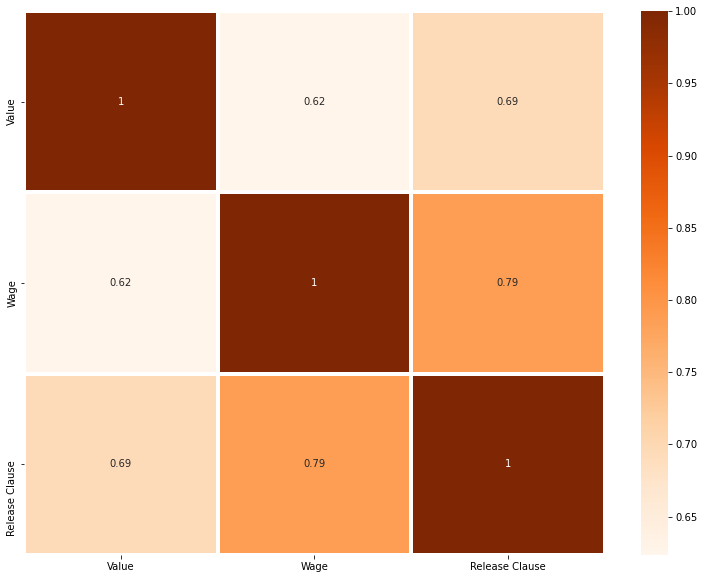

In [9]:
plt.figure(figsize=(13,10))
sns.heatmap(df[['Value', 'Wage', 'Release Clause']].corr(), cmap="Oranges", annot=True, linewidths=3)

### Мы использовали только 3 переменные, так как у нас ценовыми фичами являлись всего 2 независимые и 1 зависимая переменные.  Видно, что зарплата футболиста сильно коррелирует с итоговой стоимостью выкупа.

---

### 2) Хотим понять, как физические параметры спортсмена коррелируют с его стоимостью выкупа. Перечислим фичи, непосредственно описывающие физические параметры спортсмена:

In [20]:
model_research = df[['Age','Nationality','Preferred Foot', 'Weak Foot', 'Work Rate', 'Body Type','Height', 'Weight','Crossing', 'HeadingAccuracy', 'Acceleration','SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower','Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression','Vision','Release Clause']]
model_research

,Age,Nationality,Preferred Foot,Weak Foot,Work Rate,Body Type,Height,Weight,Crossing,HeadingAccuracy,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Vision,Release Clause
0,31,Argentina,Left,4.0,Medium/ Medium,Messi,5'7,159lbs,84.0,70.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,94.0,2.265000e+09
1,33,Portugal,Right,4.0,High/ Low,C. Ronaldo,6'2,183lbs,84.0,89.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,82.0,1.271000e+09
2,26,Brazil,Right,5.0,High/ Medium,Neymar,5'9,150lbs,79.0,62.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,87.0,2.281000e+09
3,27,Spain,Right,3.0,Medium/ Medium,Lean,6'4,168lbs,17.0,21.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,68.0,1.386000e+09
4,27,Belgium,Right,5.0,High/ High,Normal,5'11,154lbs,93.0,55.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,94.0,1.964000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,19,England,Right,2.0,Medium/ Medium,Lean,5'9,134lbs,34.0,40.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,52.0,1.430000e+05
18203,19,Sweden,Right,2.0,Medium/ Medium,Normal,6'3,170lbs,23.0,52.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,33.0,1.130000e+05
18204,16,England,Right,3.0,Medium/ Medium,Normal,5'8,148lbs,25.0,46.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,43.0,1.650000e+05
18205,17,England,Right,3.0,Medium/ Medium,Lean,5'10,154lbs,44.0,39.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,47.0,1.430000e+05


Узнаем, какие фичи важнее остальных:

In [21]:
for column in model_research.select_dtypes(include = ['object']).columns.tolist():
    model_research[column] = model_research[column].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
lgbm_regressor = lgbm.LGBMRegressor().fit(model_research.loc[:, model_research.columns != 'Release Clause'], model_research['Release Clause'])

In [23]:
list_of_importances = list(zip(model_research.loc[:, model_research.columns != 'Release Clause'].columns.tolist(), 
                               lgbm_regressor.feature_importances_))

In [24]:
sorted(list_of_importances, key= lambda x: x[1], reverse= True)

[('Reactions', 509),
 ('Vision', 316),
 ('Age', 273),
 ('LongShots', 224),
 ('HeadingAccuracy', 193),
 ('ShotPower', 165),
 ('Crossing', 155),
 ('SprintSpeed', 151),
 ('Nationality', 133),
 ('Aggression', 130),
 ('Acceleration', 119),
 ('Strength', 111),
 ('Weight', 103),
 ('Jumping', 98),
 ('Stamina', 92),
 ('Agility', 88),
 ('Balance', 64),
 ('Body Type', 26),
 ('Height', 18),
 ('Work Rate', 13),
 ('Weak Foot', 10),
 ('Preferred Foot', 9)]

Наиболее важными оказались Реакция, Зрение и Возраст. Посмотрим на их распределение относительно целевой фичи стоимость выкупа:

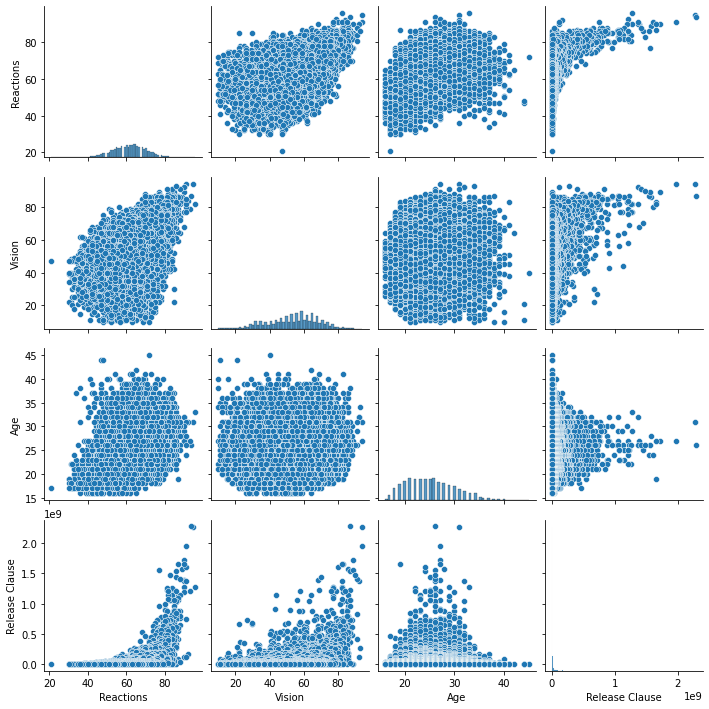

In [28]:
sns.pairplot(model_research[['Reactions', 'Vision', 'Age', 'Release Clause']])

### Несколько выводов: чем выше реакция, тем выше стоимость. Чем лучше зрение, тем выше стоимость. В возрасте от 20 до 30 присутствуют самые высокооплачиваемые спортсмены.

---

### 3) Проверим, насколько национальность влияет на психологический профиль спортсмена:

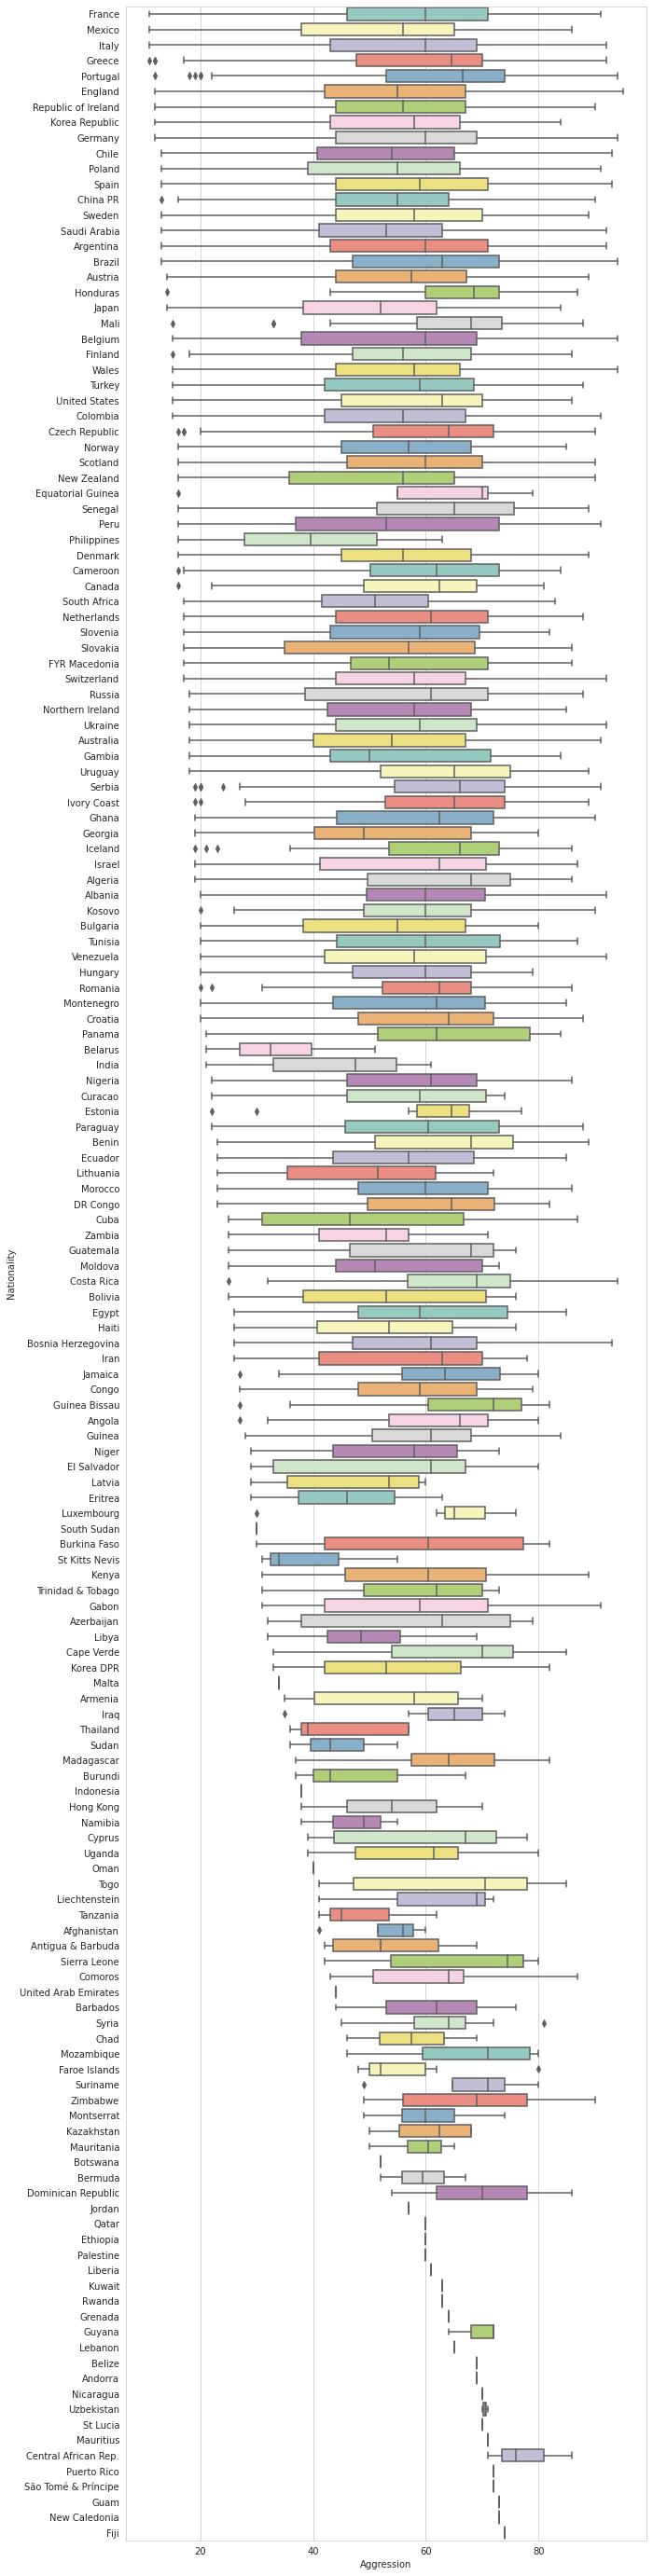

In [43]:
plt.figure(figsize=(10,50))
sns.set_style("whitegrid")
ax = sns.boxplot(x="Aggression", y="Nationality", data=df, palette="Set3")

### Наибольшую агрессию проявляют спортсмены из Серра-Леоне

---

### 4) Посмотрим на распределение объемов клубов:

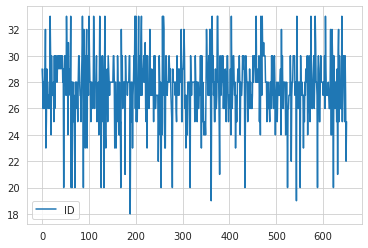

In [71]:
df.groupby('Club', as_index=False).agg({'ID':'count'}).plot()

### оказывается, среди клубов нет явных лидеров по числу спортсменов в них. 

---

### 5) Проанализируем другую ситуацию: посмотрим, спортсмены каких клубов имеют бОльшую стоимость

In [44]:
!pip install squarify

In [58]:
a = df.groupby('Club')[['Release Clause']].sum().index.get_level_values(0).tolist()

In [59]:
d = df.groupby('Club')[['Release Clause']].sum().reset_index()['Release Clause'].values.tolist()

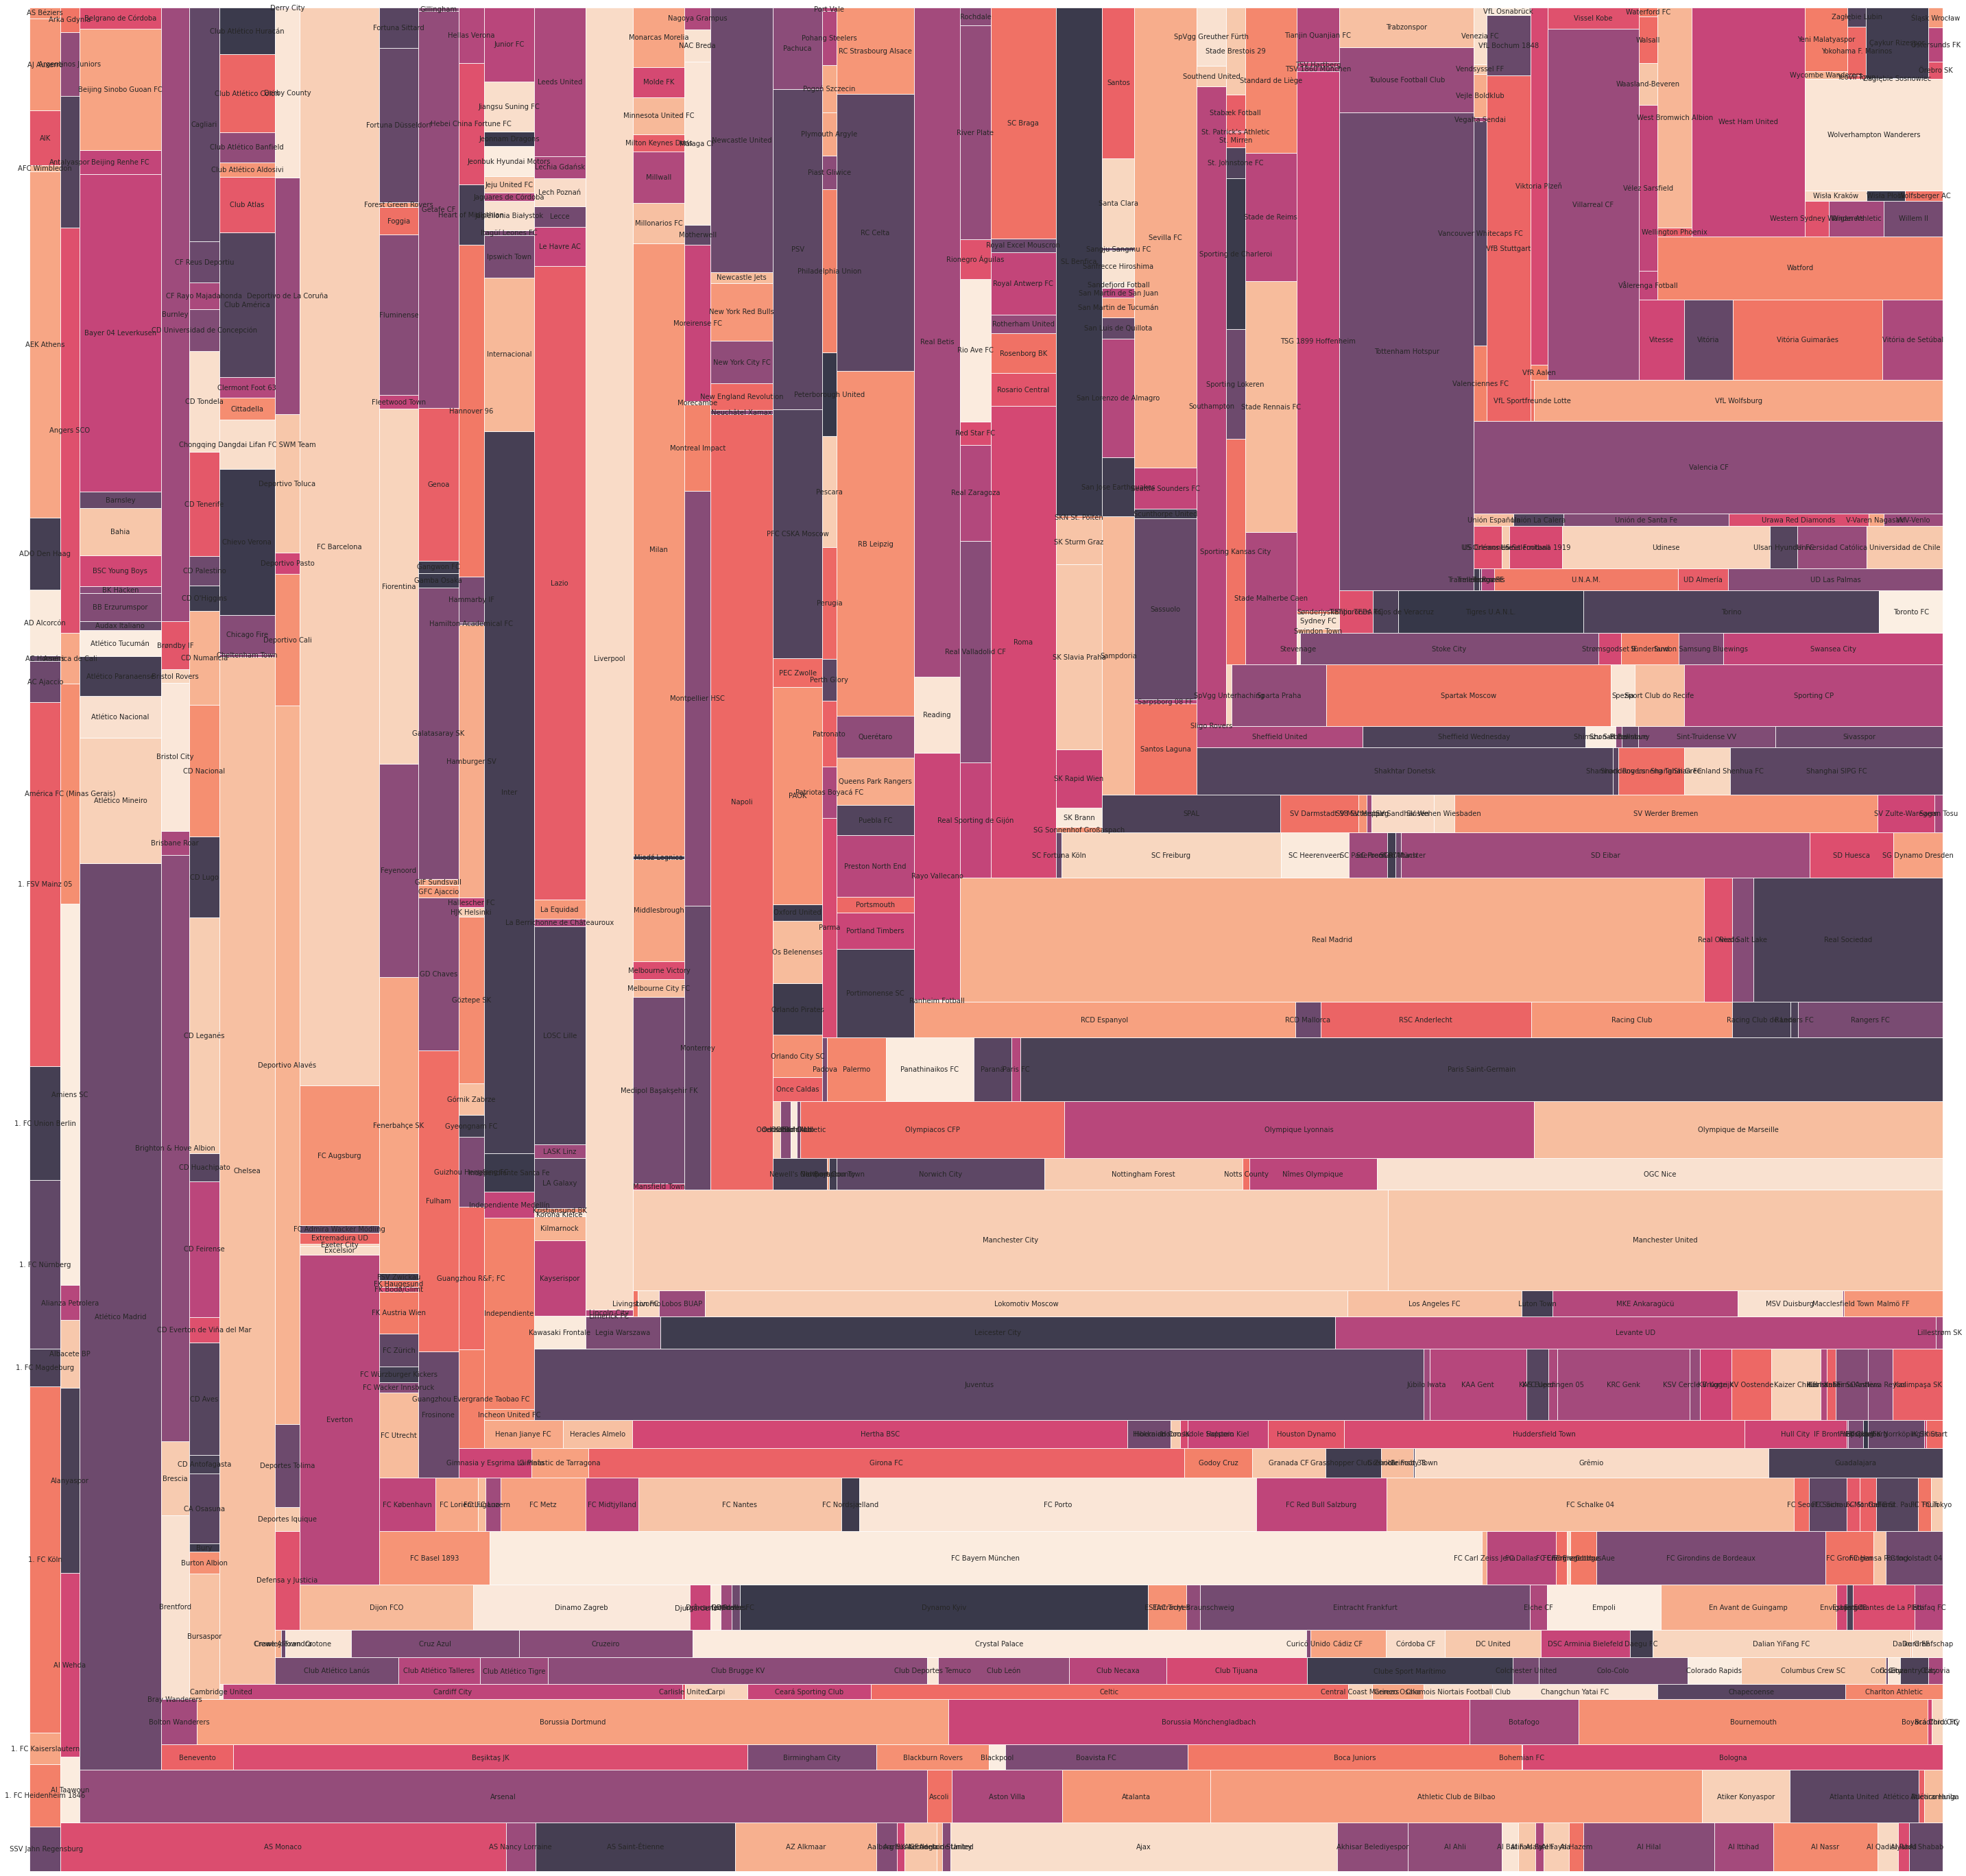

In [60]:
import squarify 
plt.figure(figsize=(50,50))
squarify.plot(sizes=d, label=a, alpha=.8)
plt.axis('off')
plt.show()

### Больше всех бросается в глаза Барелона и Реал Мадрид